# Segment Anything Model (SAM): Zero-Shot Interactive Segmentation

This notebook demonstrates how to use Meta AI's **Segment Anything Model (SAM)** from the HuggingFace `transformers` library. SAM is a promptable foundation model that can segment any object in any image without fine‑tuning.

We'll explore three types of prompts:
- **Point prompts** – a single click on an object.
- **Bounding box prompts** – a rough box around an object.
- **Automatic mask generation** – SAM proposes masks for the whole image.

## 1. Setup and Imports

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install torch torchvision torchaudio
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install transformers accelerate safetensors
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from transformers import SamModel, SamProcessor

print("PyTorch version:", torch.__version__)
import transformers
print("Transformers version:", transformers.__version__)

PyTorch version: 2.10.0+cpu
Transformers version: 5.2.0


## 2. Load Pre‑trained SAM Model and Processor

We'll use the `facebook/sam-vit-base` model (you can also try `sam-vit-large` for higher quality, at the cost of speed).

In [2]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model.eval()
print("Model loaded successfully.")

config.json: 0.00B [00:00, ?B/s]

c:\Users\Thegeek\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Thegeek\.cache\huggingface\hub\models--facebook--sam-vit-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/314 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

The image processor of type `SamImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Model loaded successfully.


## 3. Load an Image

We'll use a sample image from the COCO dataset. You can replace this with any image.

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
print("Image size:", image.size)

Image size: (640, 480)


## 4. Helper Function to Visualize Masks

We'll define a function that overlays segmentation masks on the original image.

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(patches.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## 5. Point Prompt Segmentation

We'll provide a single point on the cat (foreground) and let SAM generate masks. Because a single point can be ambiguous, SAM outputs **three candidate masks** with different granularities (whole object, part, sub‑part).

In [5]:
# Define a point on the cat (foreground)
input_points = [[[500, 375]]]  # format: batch, number of points, (x,y)
input_labels = [[1]]  # 1 = foreground

# Preprocess
inputs = processor(image, input_points=input_points, input_labels=input_labels, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process masks to original image size
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)[0]
iou_scores = outputs.iou_scores.cpu()

print(f"Generated {masks.shape[0]} candidate masks.")
print("IoU scores:", iou_scores.numpy().flatten())

Generated 1 candidate masks.
IoU scores: [0.9759672  0.97046524 0.8691399 ]


ValueError: cannot reshape array of size 921600 into shape (480,640,1)

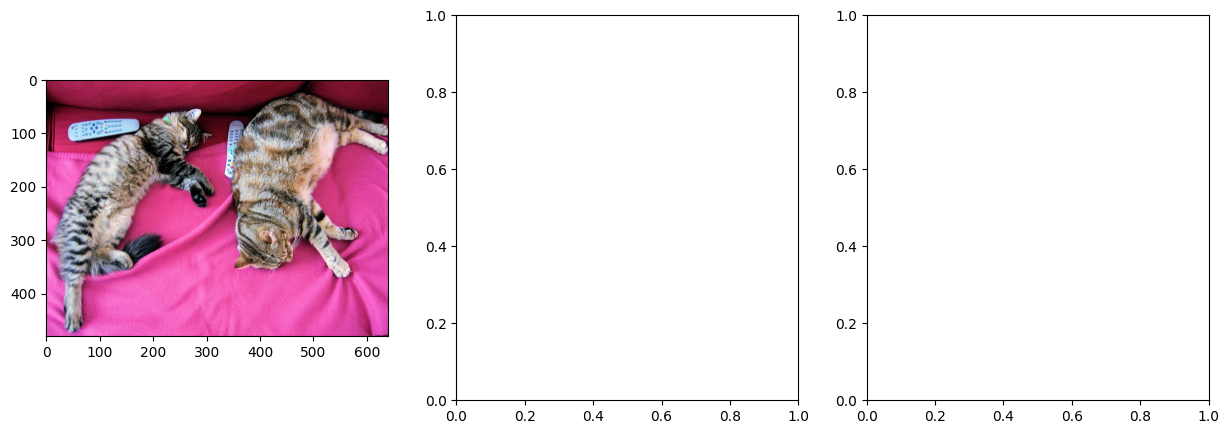

In [6]:
# Visualize all three candidate masks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (mask, score) in enumerate(zip(masks, iou_scores)):
    ax = axes[i]
    ax.imshow(image)
    show_mask(mask.numpy(), ax)
    show_points(np.array(input_points[0]), np.array(input_labels[0]), ax)
    ax.set_title(f"Mask {i+1} | IoU: {score.item():.3f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 6. Bounding Box Prompt

Instead of a point, we can provide a bounding box around the object of interest. SAM will segment the object inside the box.

In [ ]:
# Define a bounding box around the cat (x1, y1, x2, y2)
input_boxes = [[[450, 300, 750, 550]]]  # format: batch, number of boxes, coordinates

inputs = processor(image, input_boxes=input_boxes, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)[0]

# Visualize the best mask (highest IoU score)
best_idx = outputs.iou_scores.argmax().item()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image)
show_mask(masks[best_idx].numpy(), ax)
show_box(input_boxes[0][0], ax)
ax.set_title(f"Box prompt segmentation (IoU: {outputs.iou_scores[0,best_idx]:.3f})")
ax.axis('off')
plt.show()

## 7. Automatic Mask Generation

SAM can also generate masks for the whole image without any prompts. This is useful for exploring all possible objects in a scene.

**Note:** Automatic generation requires a slightly different API – we'll use the `SamAutomaticMaskGenerator` from the `transformers` library.

In [ ]:
from transformers import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(model)

# Generate masks
masks_auto = mask_generator.generate(image)
print(f"Generated {len(masks_auto)} masks.")

In [ ]:
# Visualize a subset of masks (e.g., first 10)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(image)
ax.axis('off')

sorted_masks = sorted(masks_auto, key=(lambda x: x['area']), reverse=True)
for ann in sorted_masks[:10]:
    m = ann['segmentation']
    if m.ndim == 2:
        show_mask(m, ax, random_color=True)
plt.title("Automatic masks (top 10 by area)")
plt.show()

## 8. How SAM Works – Recap

SAM consists of three main components:

1. **Image Encoder** (Vision Transformer pre‑trained with MAE):
   - Input image (1024×1024) → patches (16×16) → sequence of 4096 tokens.
   - Transformer encoder produces context‑rich features.
   - Reshaped to a 64×64 spatial feature map with 256 channels.

2. **Prompt Encoder**:
   - *Sparse prompts* (points, boxes) → token embeddings (256‑D).
   - *Dense prompts* (coarse masks) → added element‑wise to image features.
   - Output tokens (4 learnable tokens) initialize the mask decoder.

3. **Mask Decoder**:
   - Takes concatenated token sequence (prompt + output tokens) and spatial image features.
   - Uses self‑attention and cross‑attention to refine masks.
   - Upsamples features and computes dot products to generate up to 3 masks per prompt.
   - Also predicts IoU scores for each mask.

**Training**: The model was trained on the SA‑1B dataset (1.1 billion masks) using a three‑stage data engine that progressed from fully manual annotation to fully automatic mask generation.

## 9. Next Steps

- Try different point prompts – you can provide multiple points (both foreground and background) to refine the mask.
- Use SAM with a text encoder (e.g., CLIP) for text‑prompted segmentation.
- Fine‑tune SAM on a custom dataset (e.g., medical images).
- Build an interactive Gradio demo.